In [5]:
import pandas as pd
import numpy as np

def generate_summary_table(csv_path="time_resolved_dynamics_with_variance_and_mem.csv"):
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"Error: CSV file '{csv_path}' not found.")
        print("Please ensure this script is run in the same directory as time_resolved_dynamics_with_variance_and_mem.csv.")
        return

    df['CurrentStd'] = np.sqrt(df['CurrentVar'])
    df['RateStd'] = np.sqrt(df['RateVar'])
    df['MemStd'] = np.sqrt(df['MemVar'])
    
    # 更新: 在聚合中加入膜电位统计 mu_V 和 sigma_V
    summary_df = df.groupby(['Mode', 'Layer']).agg(
        mu_I=('AvgCurrent', 'mean'),
        sigma_I=('CurrentStd', 'mean'),
        mu_V=('AvgMem', 'mean'),      
        sigma_V=('MemStd', 'mean'),    
        mu_nu=('AvgRate', 'mean'),
        sigma_nu=('RateStd', 'mean')
    ).reset_index()

    epsilon = 1e-9  
    summary_df['Rate CV'] = summary_df['sigma_nu'] / (np.abs(summary_df['mu_nu']) + epsilon)

    summary_df['Layer'] = summary_df['Layer'].str.replace('layer', 'Layer ')
    

    final_table = summary_df.pivot_table(
        index='Layer',
        columns='Mode',
        values=['mu_I', 'sigma_I', 'mu_V', 'sigma_V', 'mu_nu', 'Rate CV']
    )

    desired_mode_order = ['Dissipative', 'Expansive', 'Transition']

    desired_metric_order = ['mu_I', 'sigma_I', 'mu_V', 'sigma_V', 'mu_nu', 'Rate CV']
    
    final_table = final_table.reindex(columns=desired_mode_order, level='Mode')
    final_table = final_table.reindex(columns=desired_metric_order, level=0)

    print(final_table.to_string(float_format="%.3f"))


if __name__ == "__main__":
    generate_summary_table(csv_path="time_resolved_dynamics_with_variance_and_mem.csv")

               mu_I                          sigma_I                             mu_V                          sigma_V                            mu_nu                          Rate CV                     
Mode    Dissipative Expansive Transition Dissipative Expansive Transition Dissipative Expansive Transition Dissipative Expansive Transition Dissipative Expansive Transition Dissipative Expansive Transition
Layer                                                                                                                                                                                                        
Layer 1       0.028   420.783      0.041       0.207  5327.060      0.200       0.032   441.631      0.088       0.544  5593.589      0.510       0.044     0.402      0.033       4.408     0.992      5.384
Layer 2       0.151     0.537      0.121       0.270     0.596      0.327       0.331     0.747      0.303       0.425     1.042      0.521       0.086     0.418      0.078    


--- Mean Output Firing Rate Relative Volatility (Lower is Better) ---
Mode
Dissipative    3.167978
Expansive      1.109285
Transition     3.698596
Name: RateRelVolatility, dtype: float64

Validation plot saved to theory_validation_plot.png


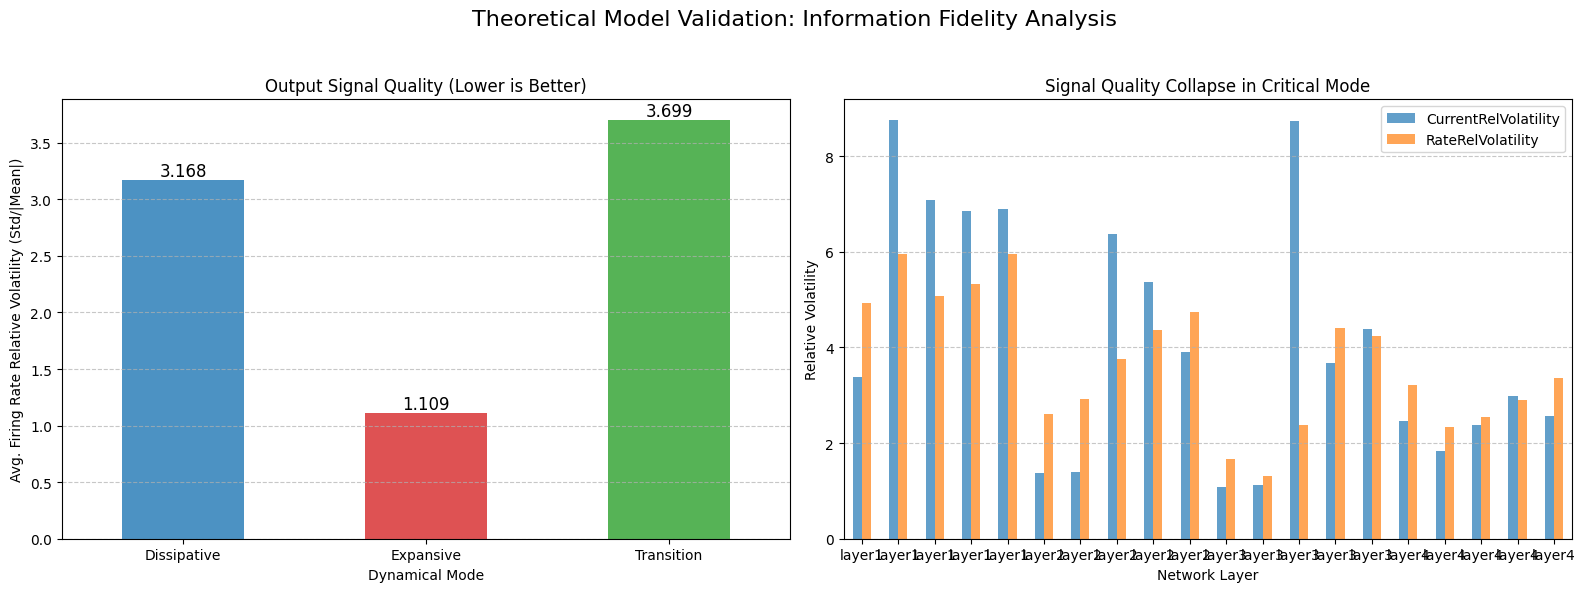

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_information_fidelity(csv_path="time_resolved_dynamics_with_variance_and_mem.csv"):
    """
    Loads data from a CSV file, calculates and analyzes key metrics to validate the theory.
    """
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"Error: CSV file '{csv_path}' not found. Please ensure the file exists in the script's directory.")
        return

    # --- 1. Calculate key derived metrics ---
    
    # Calculate standard deviation
    df['CurrentStd'] = np.sqrt(df['CurrentVar'])
    df['RateStd'] = np.sqrt(df['RateVar'])
    
    # Calculate relative volatility (CV = Std / |Mean|), as a proxy for signal-to-noise ratio (lower value means higher SNR)
    # Add a small epsilon to avoid division by zero
    epsilon = 1e-9
    df['CurrentRelVolatility'] = df['CurrentStd'] / (np.abs(df['AvgCurrent']) + epsilon)
    df['RateRelVolatility'] = df['RateStd'] / (np.abs(df['AvgRate']) + epsilon)

    # --- 2. Extract core data for plotting ---
    
    # We mainly focus on the quality of the output firing rate
    output_fidelity = df.groupby('Mode')['RateRelVolatility'].mean().reindex(['Dissipative', 'Expansive', 'Transition'])
    
    print("\n--- Mean Output Firing Rate Relative Volatility (Lower is Better) ---")
    print(output_fidelity)

    # --- 3. Visualize validation ---
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle("Theoretical Model Validation: Information Fidelity Analysis", fontsize=16)
    
    # Plot 1: Compare the average output firing rate relative volatility of the three modes
    ax1 = axes[0]
    colors = {'Dissipative': '#1f77b4', 'Expansive': '#d62728', 'Transition': '#2ca02c'}
    output_fidelity.plot(kind='bar', ax=ax1, color=[colors[m] for m in output_fidelity.index], alpha=0.8)
    ax1.set_title("Output Signal Quality (Lower is Better)")
    ax1.set_ylabel("Avg. Firing Rate Relative Volatility (Std/|Mean|)")
    ax1.set_xlabel("Dynamical Mode")
    ax1.tick_params(axis='x', rotation=0)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add numerical labels to each bar
    for i, val in enumerate(output_fidelity):
        ax1.text(i, val, f'{val:.3f}', ha='center', va='bottom', fontsize=12)
        
    # Plot 2: Analyze the evolution of signal quality in the critical mode layer by layer
    ax2 = axes[1]
    critical_data = df[df['Mode'] == 'Transition'].set_index('Layer')
    critical_data[['CurrentRelVolatility', 'RateRelVolatility']].plot(kind='bar', ax=ax2, alpha=0.7)
    ax2.set_title("Signal Quality Collapse in Critical Mode")
    ax2.set_ylabel("Relative Volatility")
    ax2.set_xlabel("Network Layer")
    ax2.tick_params(axis='x', rotation=0)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    save_path = "theory_validation_plot.png"
    plt.savefig(save_path, dpi=300)
    print(f"\nValidation plot saved to {save_path}")
    plt.show()


if __name__ == "__main__":
    analyze_information_fidelity()